In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [28]:
# read LMP data from csv into a new dataframe
prices = pd.read_csv('../data/prices_raw.csv')

# reindex and drop unused index columns
prices.index = pd.DatetimeIndex(start='2018-01-01 00:00:00',end='2018-07-31 23:00:00',freq='h')
prices = prices.drop(['Date','Hour Ending'],axis=1)

# interpolate over missing values (only 10 total)
prices = prices.interpolate(method='linear')

In [37]:
# load actual electricity demand data
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')
elec.drop('Davenport',axis=1,inplace=True)
elec_total = pd.DataFrame(elec.sum(axis=1).values,columns=['Actual'],index=elec.index)

# load forecasted electricity demand data
forecast = pd.read_csv('../data/elec_forecast.csv',index_col=0)
forecast.index = pd.to_datetime(forecast.index,format='%Y-%m-%d %H:00:00')

In [82]:
# populate columns
totals = pd.DataFrame(forecast['aggregate_forecast'].values,columns=['Forecast kWh'],index=forecast.index)
totals = totals.join(prices).join(elec_total)

totals = totals.rename({'Day Ahead LMP':'DA $/MWh',
                        'Real Time LMP':'RT $/MWh',
                        'Actual':'Actual kWh',
                       },axis='columns')

totals['DA Charge $'] = (totals['Forecast kWh']/1000)*totals['DA $/MWh']
totals['Error kWh'] = totals['Actual kWh'] - totals['Forecast kWh']
totals['RT Charge $'] = (totals['Error kWh']/1000)*totals['RT $/MWh']
totals['Net Charge $'] = totals['DA Charge $'] + totals['RT Charge $']

totals = totals[['Forecast kWh','DA $/MWh','DA Charge $',
                 'Actual kWh','RT $/MWh','RT Charge $',
                 'Error kWh','Net Charge $']]
totals.head(3)

,Forecast kWh,DA $/MWh,DA Charge $,Actual kWh,RT $/MWh,RT Charge $,Error kWh,Net Charge $
2018-01-11 00:00:00,696.067917,70.44,49.031024,710.9,59.18,0.877763,14.832083,49.908787
2018-01-11 01:00:00,682.694721,69.91,47.727188,716.0,45.32,1.509395,33.305279,49.236583
2018-01-11 02:00:00,609.782541,64.01,39.032180,638.6,29.07,0.837724,28.817459,39.869904


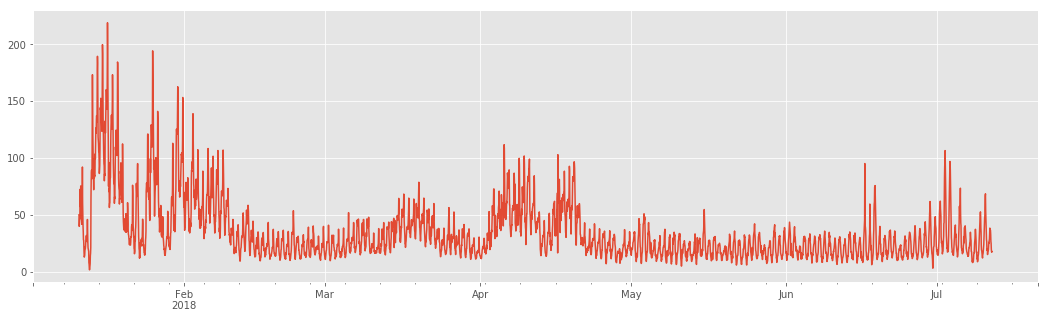

In [100]:
totals['Net Charge $'].plot(figsize=(18,5))

In [89]:
totals['Net Charge $'].sum()

149491.170356184

In [115]:
avg_rate = np.round((totals['Net Charge $'].sum()/totals['Actual kWh'].sum())*100,2)
rate_estimate = 6 # estimate for yale's current rate

savings = np.round(((rate_estimate - avg_rate) * totals['Actual kWh'].sum())/100,2)
yearly_savings = np.round(savings*(8760/len(totals)),2)

print('The average day-ahead rate is {} cents/kWh'.format(avg_rate))
print('Assuming a current rate of 6 cents/kWh, this strategy would save ${} per year.'.format(yearly_savings))


The average day-ahead rate is 4.07 cents/kWh
Assuming a current rate of 6 cents/kWh, this strategy would save $142190.82 per year.
